<h1>Nevan Ang Kai Wen
<h1>P2122867
<h1>Khor Yu Yang
<h1>P2123590
<h1>DAAA/FT/2B/01

In [12]:
from keras.optimizers import Adam
import numpy as np
from keras.layers import Dense,Activation
from keras.models import Sequential,load_model
import datetime
import gym
import matplotlib.pyplot as plt
import tensorflow as tf

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [14]:
tf.compat.v1.disable_eager_execution()

<h2>Replay Buffer

Storage of state,action,reward,state transition,tuples and done(terminal)

So that agent can use transitions to learn about parameter space of problem

In [17]:
class ReplayBuffer():
    def __init__(self,max_size,input_shape,n_actions,discrete=True):
        self.mem_size=max_size
        self.mem_cntr=0
        self.discrete=discrete #if dealt with discrete action space, we want to store them as vector
        self.state_mem=np.zeros((self.mem_size,input_shape))
        #to store new states of environment
        self.new_state_mem=np.zeros((self.mem_size,input_shape)) #track new states after each new action
        dtype=np.int8 if discrete else np.float32 #discrete or continuous
        self.action_mem=np.zeros((self.mem_size,n_actions),dtype=dtype)
        self.reward_mem=np.zeros(self.mem_size)
        self.terminal_mem=np.zeros(self.mem_size,dtype=np.float32) #determine whether episode is done, dont take in reward of next state
    #learn from its experiences by storing in info about its interactions
    def store_transition(self,state,action,reward,state_,terminal):
        index=self.mem_cntr %self.mem_size #from 0 to 1m size of memory, to replace exisiting when it hits 1m 
        self.state_mem[index]=state
        self.new_state_mem[index]=state_
        self.reward_mem[index]=reward
        self.terminal_mem[index]=1-int(terminal)# 1- true or 0
        if self.discrete: #one hot encoded actions
            actions=np.zeros(self.action_mem.shape[1])
            actions[action]=1.0
            self.action_mem[index]=actions
        else:
            self.action_mem[index]=action
        self.mem_cntr+=1
        
    def sample_memory(self,batch_size): # subset of memsize
        max_mem=min(self.mem_cntr,self.mem_size)#only sample from existing 
        batch=np.random.choice(max_mem,batch_size)
        states=self.state_mem[batch]
        states_=self.new_state_mem[batch]
        rewards=self.reward_mem[batch]
        actions=self.action_mem[batch]
        terminal=self.terminal_mem[batch]
        return states,actions, rewards,states_,terminal


<h2>DQN Network

2 hidden layers of dense

In [18]:
def dqn(lr,n_actions,input_dim,fc1,fc2):
    model=Sequential([
        Dense(fc1,input_shape=(input_dim,)),#pass batch or single memory
        Activation('relu'),
        Dense(fc2),
        Activation('relu'),
        Dense(n_actions)
    ])
    model.compile(optimizer=Adam(lr=lr),loss='mse')
    return model


<h2>Agent

Where the model is run, experience stored,action chosen, generate experience and learn and to save or load models

gamma-discount factor for future rewards


epsilon-random factor for epsilon greedy

Without Target Network

In [19]:
class Agent():
    def __init__(self,alpha,gamma,n_actions,epsilon,batch_size,input_dims,epsilon_dec=0.996,epsilon_end=0.01,mem_size=1_000_000,fname='no_target_dqn_model.h5'):
        self.action_space=[i for i in range(n_actions)] # for randm action
        self.gamma=gamma
        self.epsilon=epsilon
        self.ep_dec=epsilon_dec
        self.eps_min=epsilon_end
        self.batch_size=batch_size
        self.model_file=fname

        self.memory=ReplayBuffer(mem_size,input_dims,n_actions,discrete=True)
        self.Q_eval=dqn(alpha,n_actions,input_dims,256,256)
    #interfacing w/ memory to save new state transitions
    def remember(self,state,action,reward,new_state,terminal):
        self.memory.store_transition(state,action,reward,new_state,terminal)

    #epsilon greedy strategy
    def choose_action(self,state): #shaped input dims
        #reshape
        state=state[np.newaxis,:]
        rand=np.random.random()
        if rand<self.epsilon: #exploration
            action=np.random.choice(self.action_space)
        else:
            actions=self.Q_eval.predict(state,verbose=0)
            action=np.argmax(actions)#pass state through the network,get value of all actions and get max highest value
        return action

        ###Sample Memory,
        #Calculate value of current and next state
        #Update q_target based on next state as target for loss function of q_eval
    def learn(self):
        #Temporal difference learning method: learning every step, fill memory with random until batchsize
        if self.memory.mem_cntr<self.batch_size:
            return
        state,action,reward,new_state,terminal= self.memory.sample_memory(self.batch_size) #gives sample in shape batch_size
        action_values=np.array(self.action_space,dtype=np.int8)
        action_indices=np.dot(action,action_values) #from one hot to normal integer
        Q_eval=self.Q_eval.predict(state,verbose=0) #feed state through model to calculate current and next state 
        Q_next=self.Q_eval.predict(new_state,verbose=0)
        q_target=Q_eval.copy()
        #Address all states in particular batch, not normal array slicing because Shape(batchsize,batchsize) gives u wrong answer 
        batch_index=np.arange(self.batch_size,dtype=np.int32)
        q_target[batch_index,action_indices]= reward+self.gamma*np.max(Q_next,axis=1)*terminal #what q target shoots for
        #best possible reward received in next state 
        #0 to batchsize-1,action taken
        self.Q_eval.train_on_batch(state,q_target)#pass batch to network, compare to q target and 

        # self.epsilon=self.epsilon*self.ep_dec if self.epsilon > self.eps_min else self.eps_min
        if self.epsilon-1e-4>self.eps_min:
            self.epsilon*=self.ep_dec
        else:
            self.epsilon=self.eps_min
    def save_model(self,i):
        self.Q_eval.save(f'ep{i}_{self.model_file}')
    def load_model(self):
        self.Q_eval=load_model(self.model_file)

In [21]:
env=gym.make("LunarLander-v2")
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


<h2>Training

In [22]:
from torch.utils.tensorboard import SummaryWriter
agent=Agent(gamma=0.99,epsilon=1.0,alpha=0.001,input_dims=8,n_actions=4,batch_size=128,epsilon_end=0.01)
#agent scores
scores,eps_hist=[],[] #ontaining scores from each episode/epsiolon
# scores_window =[] #every 100 epsiode
episode=200
for i in range(episode):
    score=0
    terminate=False
    observation=env.reset()
    while not terminate:
        action=agent.choose_action(observation)
        observation_,reward,terminate,info=env.step(action)
        score+= reward
        agent.remember(observation,action,reward,observation_,terminate)
        observation=observation_
        agent.learn()
    scores.append(score)
    eps_hist.append(agent.epsilon)
    avg=np.mean(scores[max(0,i-100):(i+1)])#last 100 games
    print('Ep ',i+1, 'score %.2f'%score,'avg score %.2f'%avg,'epsilon %.2f'%agent.epsilon)
    # if i%10==0 and i>0:
    #     agent.save_model(i)
    # writer_score.add_image
    # if i % 100 == 0:
    #     print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
    # if np.mean(scores_window)>=200.0:
    #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
x=[i+1 for i in range(episode)]
env.close()

Ep  1 score -260.64 avg score -260.64 epsilon 1.00
Ep  2 score -250.47 avg score -255.56 epsilon 0.81
Ep  3 score -100.62 avg score -203.91 epsilon 0.48
Ep  4 score -163.07 avg score -193.70 epsilon 0.24
Ep  5 score -173.54 avg score -189.67 epsilon 0.01
Ep  6 score -94.82 avg score -173.86 epsilon 0.01
Ep  7 score -218.27 avg score -180.20 epsilon 0.01
Ep  8 score -95.62 avg score -169.63 epsilon 0.01
Ep  9 score -321.82 avg score -186.54 epsilon 0.01
Ep  10 score -62.75 avg score -174.16 epsilon 0.01
Ep  11 score -82.57 avg score -165.83 epsilon 0.01
Ep  12 score -83.60 avg score -158.98 epsilon 0.01
Ep  13 score -108.68 avg score -155.11 epsilon 0.01
Ep  14 score -66.90 avg score -148.81 epsilon 0.01
Ep  15 score -94.49 avg score -145.19 epsilon 0.01
Ep  16 score -111.68 avg score -143.10 epsilon 0.01
Ep  17 score -66.73 avg score -138.60 epsilon 0.01
Ep  18 score -73.51 avg score -134.99 epsilon 0.01
Ep  19 score -62.87 avg score -131.19 epsilon 0.01
Ep  20 score -67.04 avg score -

<h2>Moving Average across episodes

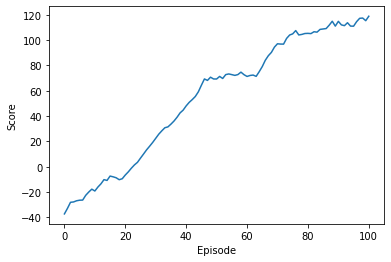

In [23]:
def moving_average(a, n=100) : #calculating the average of a certain number of data points over a fixed period of time.
    #average of a certain number of consecutive data points, and then sliding the window of data points over the entire dataset, 
    #updating the average as the window moves. 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def plot_scores(scores):
    scores_ma=moving_average(scores,n=100)
    plt.plot(np.arange(len(scores_ma)), scores_ma)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()
    
plot_scores(scores)

<h2>Rewards over all Episodes

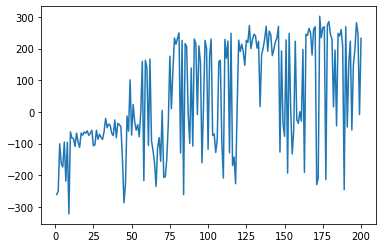

In [24]:
plt.plot(x,scores)